In [58]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
import os
import cv2
import json

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [35]:
base_dir = "./training"

IMAGE_WIDTH  = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 32

Criando um gerador de dados que aplicará técnicas de data augmentation ao dataset.

In [36]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  fill_mode='nearest',
  zoom_range=0.3,
  width_shift_range=0.3,
  height_shift_range=0.3,
  rotation_range=30)

Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [37]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Criando uma função que retornará um modelo com base na arquitetura DenseNet 201, treinada com os pesos da ImageNet, sem a camada superior, de classificação. É adicionada ao modelo uma camada Fully Connected para a classificação dos 49 labels.

In [38]:
def getModel():
  base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
  )

  base_model.trainable = True
  
  model = tf.keras.Sequential([
      base_model,  # 1
      tf.keras.layers.GlobalAveragePooling2D(),  # 4
      tf.keras.layers.Dense(49, activation='softmax')  # 5
  ])

  model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, momentum=0.9),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3

  return model

Utilizando Stratified 5-fold Cross-validation para treinamento/validação do modelo

In [39]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Carregando nomes dos arquivos de imagem e seus respectivos rótulos

In [40]:
filenames = []
labels    = []

for classname in os.listdir(base_dir):
  class_dir = os.path.join(base_dir, classname)
  if os.path.isdir(class_dir):
    for filename in os.listdir(class_dir):
      if filename.lower().endswith(".jpg"):
        labels.append(classname)
        filenames.append(os.path.join(class_dir, filename))

filenames = np.array(filenames)
labels    = np.array(labels)

Mostrando histograma do dataset utilizado

/Users/kallebe/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


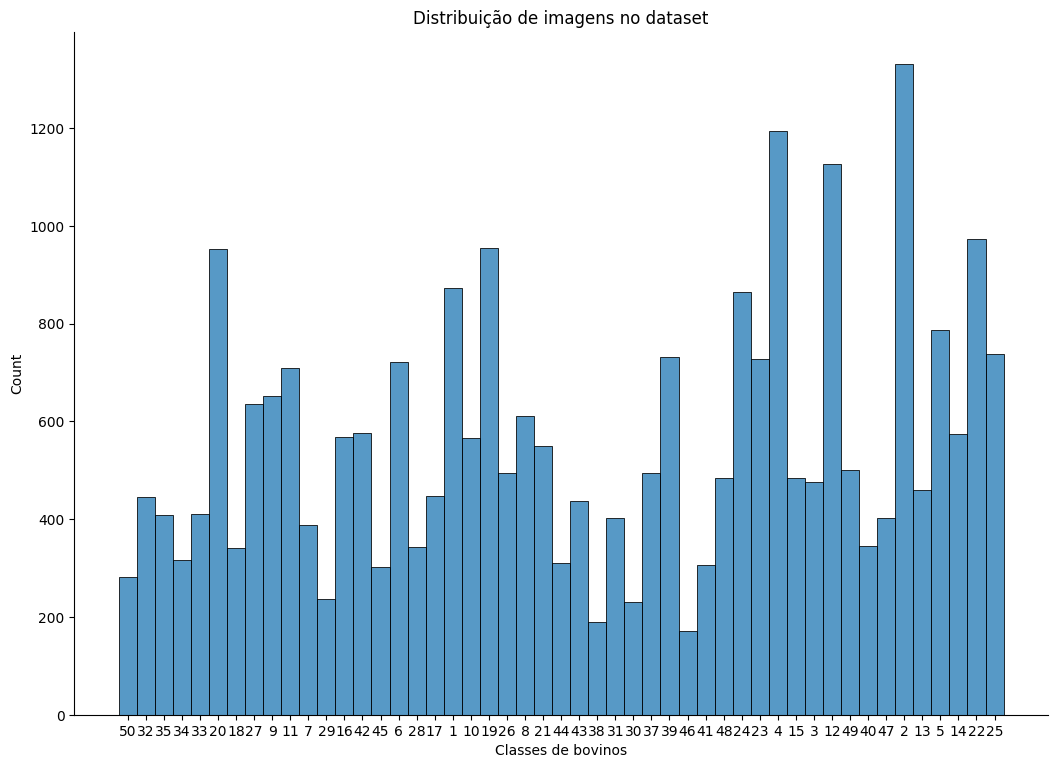

In [41]:
data_df = pd.DataFrame({'data': filenames, 'labels': labels})

ax=sns.displot(data_df, x='labels', bins=50)
ax.set(xlabel='Classes de bovinos', title='Distribuição de imagens no dataset')
ax.figure.set_size_inches(12,8)
plt.show()

Particionando o dataset em conjunto de treinamento e conjunto de teste.

In [42]:
train_data, test_data, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.1, random_state=42, stratify=labels)

In [43]:
test_set = {
  "data": test_data.tolist(),
  "labels": test_labels.tolist()
}

json_test_set = json.dumps(test_set, indent=2)

with open('test_set.json', 'w') as file:
  file.write(json_test_set)

Definindo as épocas para o treinamento da model

In [44]:
epochs = 20
history_list = []

Escreve divisão do dataset da validação cruzada em um arquivo

In [45]:
folds_training_validation = []

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(train_data, train_labels)):
  fold_resultado = {
    "fold": fold + 1,
    "training": {
      "indexes": train_index.tolist(),
      "data": train_data[train_index].tolist(),
      "labels": train_labels[train_index].tolist()
    },
    "validation": {
      "indexes": val_index.tolist(),
      "data": train_data[val_index].tolist(),
      "labels": train_labels[val_index].tolist()
    }
  }
  folds_training_validation.append(fold_resultado)

# Converter para JSON
json_resultado = json.dumps(folds_training_validation, indent=2)

with open('cross_validation_folds.json', 'w') as file:
  file.write(json_resultado)

Carrega `history_list` a partir de arquivo

In [46]:
# if os.path.exists('history_list.json'):
#   with open('history_list.json', 'r') as file:
#     history_list = json.load(file)

Define o último fold usado para treinamento/validação:

In [62]:
last_fold = 0

Aplicando o Stratified 10-fold Cross-Validation

In [63]:
folds_training_validation_from_last_fold = folds_training_validation[last_fold:]
for fold in folds_training_validation_from_last_fold:
  print(f"Fold {fold['fold']}/{n_folds}")

  # Separando os dados de treinamento e validação
  train_filenames = fold['training']['data']
  tr_labels = fold['training']['labels']

  val_filenames = fold['validation']['data']
  val_labels = fold['validation']['labels']

  # Criando geradores de dados de treinamento e validação
  train_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": train_filenames, "class": tr_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  val_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": val_filenames, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  model = getModel()

  # Treinando o modelo
  history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
  history_list.append(history.history)

  json_history = json.dumps(history_list, indent=2)
  with open('history_list.json', 'w') as file:
    file.write(json_history)
  
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
  model.save_weights(f'./checkpoints/{timestamp}')
  
  last_fold += 1

Fold 2/5
Found 19817 validated image filenames belonging to 49 classes.
Found 4954 validated image filenames belonging to 49 classes.
Epoch 1/20


2023-12-07 11:33:38.142318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


620/620 [==============================] - ETA: 0s - loss: 3.4287 - accuracy: 0.1750

2023-12-07 12:09:55.568015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


620/620 [==============================] - 2358s 4s/step - loss: 3.4287 - accuracy: 0.1750 - val_loss: 2.7894 - val_accuracy: 0.3448
Epoch 2/20
620/620 [==============================] - 2391s 4s/step - loss: 2.4424 - accuracy: 0.4464 - val_loss: 1.9577 - val_accuracy: 0.5702
Epoch 3/20
620/620 [==============================] - 2330s 4s/step - loss: 1.8132 - accuracy: 0.6100 - val_loss: 1.4590 - val_accuracy: 0.6887
Epoch 4/20
620/620 [==============================] - 2297s 4s/step - loss: 1.3910 - accuracy: 0.7208 - val_loss: 1.1290 - val_accuracy: 0.7864
Epoch 5/20
620/620 [==============================] - 2406s 4s/step - loss: 1.1005 - accuracy: 0.7868 - val_loss: 0.8790 - val_accuracy: 0.8282
Epoch 6/20
620/620 [==============================] - 2378s 4s/step - loss: 0.8963 - accuracy: 0.8283 - val_loss: 0.7118 - val_accuracy: 0.8646
Epoch 7/20
620/620 [==============================] - 2337s 4s/step - loss: 0.7451 - accuracy: 0.8544 - val_loss: 0.5907 - val_accuracy: 0.8815
Epo

KeyboardInterrupt: 

Mostrando as métricas em um gráfico

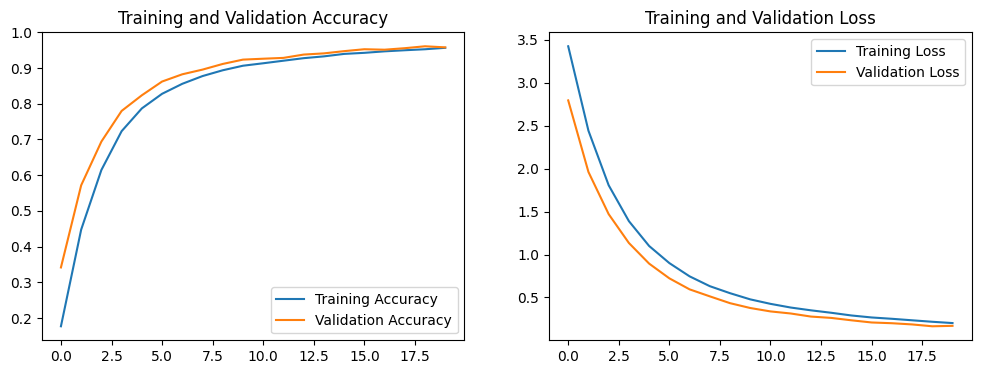

In [64]:
grupo_acc_index       = list(zip(*(d['accuracy'] for d in history_list)))
grupo_loss_index      = list(zip(*(d['val_accuracy'] for d in history_list)))
grupo_val_acc_index   = list(zip(*(d['loss'] for d in history_list)))
grupo_val_loss_index  = list(zip(*(d['val_loss'] for d in history_list)))

acc_values      = [sum(values) / len(values) for values in grupo_acc_index]
val_acc_values  = [sum(values) / len(values) for values in grupo_loss_index]
loss_values     = [sum(values) / len(values) for values in grupo_val_acc_index]
val_loss_values = [sum(values) / len(values) for values in grupo_val_loss_index]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Salvar pesos do modelo:

In [65]:
model.save_weights('./checkpoints/pesos-cattle-recognition')

Carregando pesos salvos para o modelo

In [68]:
# model = getModel()
# model.load_weights('./checkpoints/pesos-cattle-recognition')

Aplicando pré-processamento no conjunto de teste

In [69]:
data_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255
)
test_generator = data_test_generator.flow_from_dataframe(
    pd.DataFrame({"filename": test_data, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 2753 validated image filenames belonging to 49 classes.


Avaliando desempenho do modelo no conjunto de teste

In [70]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2023-12-08 01:05:56.725840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 104s 957ms/step - loss: 0.0713 - accuracy: 0.9851
Test Loss: 0.07125905156135559
Test Accuracy: 0.9851071834564209


Realizando predições no conjunto de teste.

In [71]:
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

2023-12-08 01:11:43.979912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 105s 960ms/step


Mapeando índices das classes para o vetor de predições

In [72]:
class_mapping = test_generator.class_indices
index_to_class = { v: k for k, v in class_mapping.items() }
predicted_class_names = [index_to_class[idx] for idx in predictions]

Criando matriz de confusão

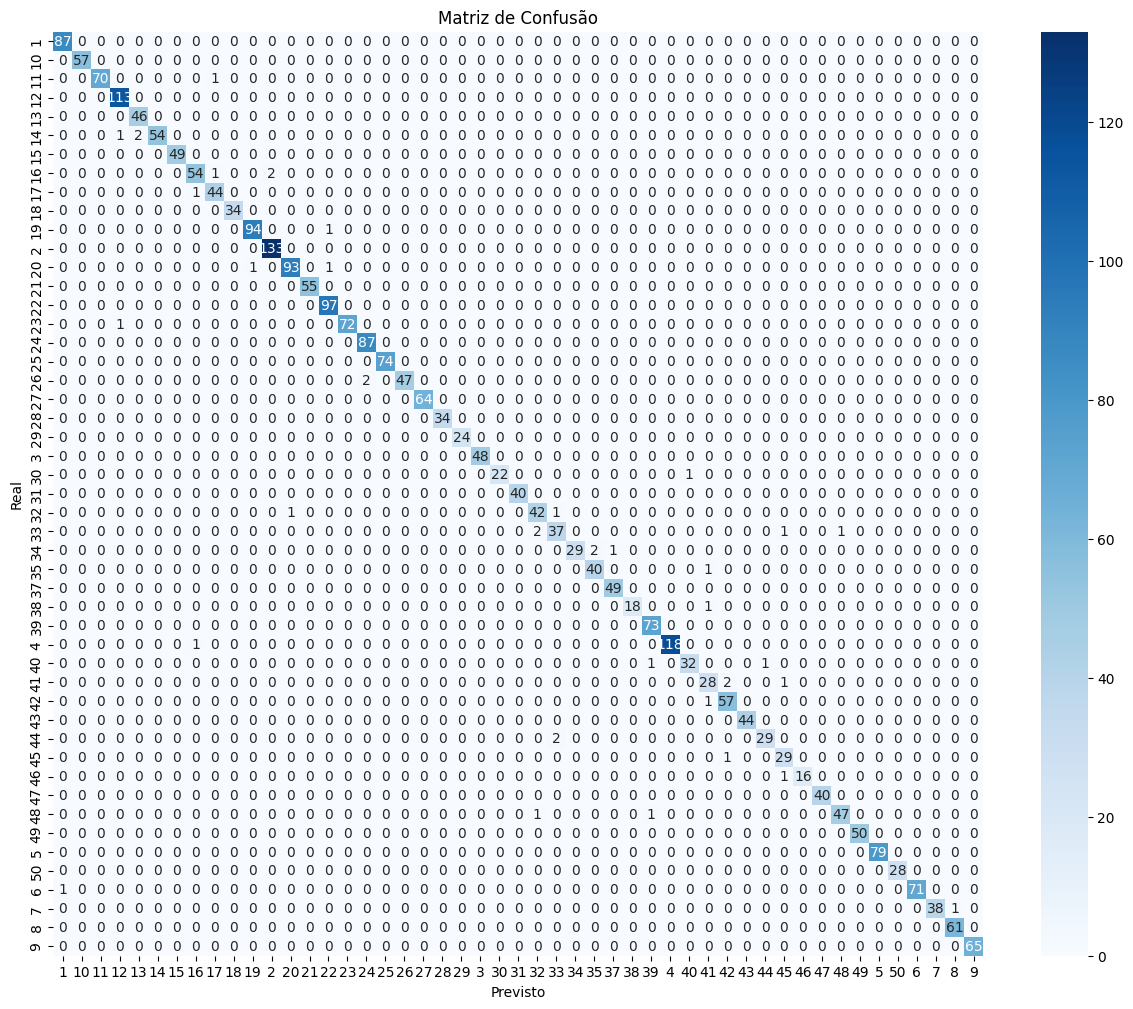

In [73]:
conf_mat = confusion_matrix(test_labels, predicted_class_names)

plt.figure(figsize=(15, 12))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [74]:
print(classification_report(test_labels, predicted_class_names))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99        87
          10       1.00      1.00      1.00        57
          11       1.00      0.99      0.99        71
          12       0.98      1.00      0.99       113
          13       0.96      1.00      0.98        46
          14       1.00      0.95      0.97        57
          15       1.00      1.00      1.00        49
          16       0.96      0.95      0.96        57
          17       0.96      0.98      0.97        45
          18       1.00      1.00      1.00        34
          19       0.99      0.99      0.99        95
           2       0.99      1.00      0.99       133
          20       0.99      0.98      0.98        95
          21       1.00      1.00      1.00        55
          22       0.98      1.00      0.99        97
          23       1.00      0.99      0.99        73
          24       0.98      1.00      0.99        87
          25       1.00    